In [378]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [379]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [380]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [381]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [382]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\gomes\AppData\Local\Temp\ipykernel_19564\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [383]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [384]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [385]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [386]:
# Find the most recent date in the data set.
from sqlalchemy import inspect
inspector = inspect(engine)

In [387]:
inspector.get_table_names()

['measurement', 'station']

In [388]:
columns = inspector.get_columns('measurement')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [389]:
columns = inspector.get_columns('station')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


In [390]:
earlieststr = session.query(Measurement.date).order_by(Measurement.date).first()
lateststr = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest: {earlieststr[0]} , Latest: {lateststr[0]}")

Earliest: 2010-01-01 , Latest: 2017-08-23


In [391]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
latestdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any') # clean up non value entries
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


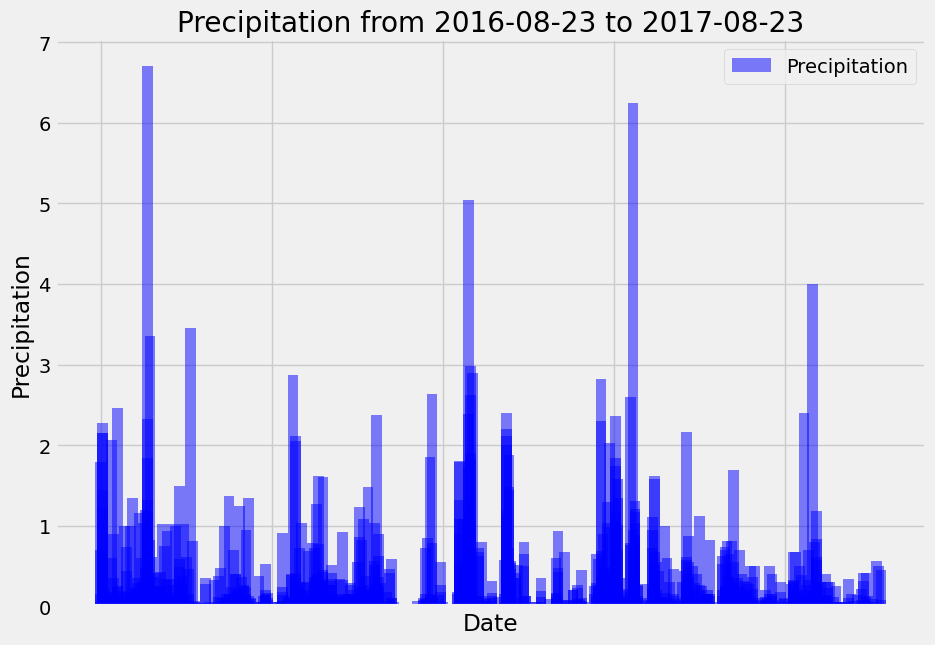

In [392]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Use Pandas Plotting with Matplotlib to plot the data

xx = precipitation.index.tolist()
yy = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {querydate} to {lateststr[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [393]:
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [394]:
# Design a query to calculate the total number of stations in the dat
session.query(Measurement.station).distinct().count()

9

In [395]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [396]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()
result

[(54.0, 85.0, 71.66378066378067)]

In [397]:
# Get the most active station
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).first()

# Define the start and end dates for the query
start_date = '2017-01-01'
end_date = '2017-12-31'

# Query the temperature data for the most active station within the specified date range
year_temp = session.query(Measurement.tobs).\
    filter(Measurement.date >= start_date, Measurement.date <= end_date, Measurement.station == most_active_station[0]).\
    order_by(Measurement.tobs).all()

In [398]:
df1 = pd.DataFrame(year_temp, columns=['Tobs'])
df1.head()

,Tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


Columns in df1: Index(['Tobs'], dtype='object')


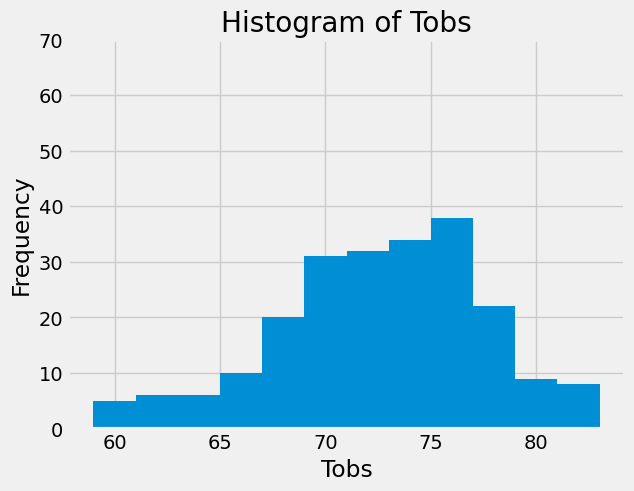

In [404]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame creation for demonstration purposes
# df1 = pd.read_csv('your_file.csv') # Load your actual DataFrame

# Check if the Images directory exists and create it if it doesn't
if not os.path.exists('Images'):
    os.makedirs('Images')

# Display the columns of df1 to check if 'Tobs' exists
print("Columns in df1:", df1.columns)

# Check if 'Tobs' is a column in df1
if 'Tobs' in df1.columns:
    bins = 12
    # Plot histogram of 'Tobs'
    df1['Tobs'].plot.hist(bins=bins)
    plt.ylim(0, 70)  # Set y-axis limit
    plt.xlabel('Tobs')  # Label for x-axis
    plt.ylabel('Frequency')  # Label for y-axis
    plt.title('Histogram of Tobs')  # Title for the plot
    plt.grid(True)  # Add grid for better readability
    plt.savefig('Images/station-histogram.png')
    plt.show()  # Display the plot
else:
    print("Column 'Tobs' does not exist in df1.")


In [405]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [406]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2018,1,1) - dt.timedelta(days= 365)
# print(prev_year_start)
prev_year_end = prev_year_start + dt.timedelta(days = 5)
#print(prev_year_end)
calc_temp = calc_temps(prev_year_start,prev_year_end)
print(calc_temp)

[(62.0, 68.05714285714286, 74.0)]


In [407]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ta_temp= list(np.ravel(calc_temp))
#ta_temp
tmin = ta_temp[0]
tmax = ta_temp[2]
temp_avg = ta_temp[1]

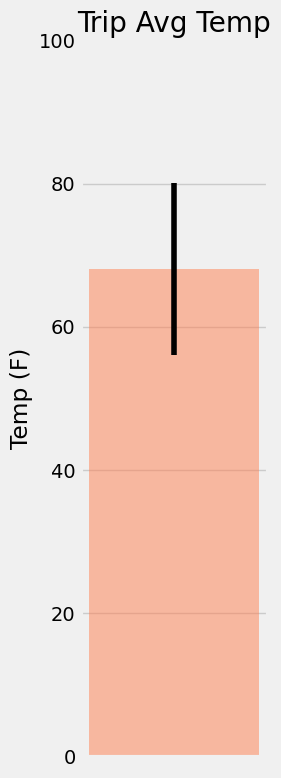

In [408]:
#fig, ax = plt.subplots()
# x = range(0,1)
# print(x)
plt.figure(figsize=(3,8))
plt.bar(1,temp_avg, color = 'coral',alpha = 0.5)
plt.errorbar(1,temp_avg, yerr=(tmax - tmin), color = 'k')
plt.ylim(0, 100)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig('Images/temperature.png')

In [410]:
from sqlalchemy import func

# Define the query to calculate rainfall per weather station for the previous year's matching dates
rainfall_query = (
    session.query(
        Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.sum(Measurement.prcp).label('total_precipitation')
    )
    .join(Measurement, Station.station == Measurement.station)
    .filter(Measurement.date >= prev_year_start)
    .filter(Measurement.date <= prev_year_end)
    .filter(Measurement.prcp != None)
    .group_by(Station.station)
    .order_by(func.sum(Measurement.prcp).desc())
)

# Execute the query and fetch all results
rainfall_station = rainfall_query.all()

# Print the results
for station in rainfall_station:
    print(station)

('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)


# Close Session

In [301]:
# Close Session
session.close()